### Validate trained policy offline

In [16]:
import torch
import os
import numpy as np
import cv2
import collections
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.gridspec as gridspec

import sys
sys.path.append('../../hannes-imitation')
sys.path.append('../../hannes-imitation/hannes_imitation/external/diffusion_policy') # NOTE otherwise importing SequenceSampler fails

# diffusion_policy imports
from hannes_imitation.external.diffusion_policy.diffusion_policy.policy.diffusion_unet_image_policy import DiffusionUnetImagePolicy
from hannes_imitation.external.diffusion_policy.diffusion_policy.common.pytorch_util import dict_apply

# hannes_imitation imports
from hannes_imitation.dataset.hannes_dataset import HannesImageDataset
from hannes_imitation.dataset.hannes_dataset_hand_wrist_FE import HannesImageDatasetWrist

from hannes_imitation.common import plot_utils
from hannes_imitation.common.data_utils import resize_image
from hannes_imitation.scripts.validate_policy import create_observation_dictionaries, evaluate_policy_on_episode, compute_episode_errors_per_horizon

In [2]:
# Load train/validation dataset
zarr_path = '/home/calessi-iit.local/Projects/hannes-imitation/data/training/merged_1_4_7.zarr' # NOTE: IROS 2025
keys = ['image_in_hand', 'ref_move_hand', 'ref_move_wrist_FE', 'ref_move_wrist_PS', 'mes_hand', 'mes_wrist_FE']
val_ratio = 0.2
seed = 72
max_train_episodes = None
horizon = 8 # default 16 # prediction horizon
observation_horizon = 2 # default 2
action_horizon = 4 # default 8
pad_before = observation_horizon - 1
pad_after = action_horizon - 1

# training and validation dataset
#train_dataset = HannesImageDataset(zarr_path, keys, horizon=horizon, pad_before=pad_before, pad_after=pad_after, seed=seed, val_ratio=val_ratio, max_train_episodes=None)
train_dataset = HannesImageDatasetWrist(zarr_path, keys, obs_horizon=observation_horizon, horizon=horizon, pad_before=pad_before, pad_after=pad_after, 
                                        seed=seed, val_ratio=val_ratio, max_train_episodes=None)
validation_dataset = train_dataset.get_validation_dataset()

In [3]:
# get global episode indeces for the training set and validation set
tr_episode_indeces = [i for i, mask in enumerate(train_dataset.train_mask) if mask]
vl_episode_indeces = [i for i, mask in enumerate(validation_dataset.train_mask) if mask]

tr_labels = [train_dataset.labels[i] for i in tr_episode_indeces]
vl_labels = [train_dataset.labels[i] for i in vl_episode_indeces]

In [7]:
# load model
policy_path = '/home/calessi-iit.local/Projects/hannes-imitation/trainings/policy_1_4_7_2025_2_19-21_10_9.pth' # iros2025
checkpoint = torch.load(policy_path)
policy = checkpoint['policy']

# device transfer
device = torch.device('cuda')
_ = policy.to(device).eval()

## Evaluate on episode

In [ ]:
# choose episode
#idx = np.random.choice(tr_episode_indeces)
idx = np.random.choice(vl_episode_indeces)

episode = train_dataset.replay_buffer.get_episode(idx)

#obs_dictionaries, actions_gt = create_observation_dictionaries(episode, observation_horizon)
action_sequences, actions_gt = evaluate_policy_on_episode(policy, episode, observation_horizon=policy.n_obs_steps) # {'executed', 'predicted'}
frames = episode['image_in_hand']
mes_hand = episode['mes_hand']
mes_wrist_FE = episode['mes_wrist_FE']

#### Episode observations

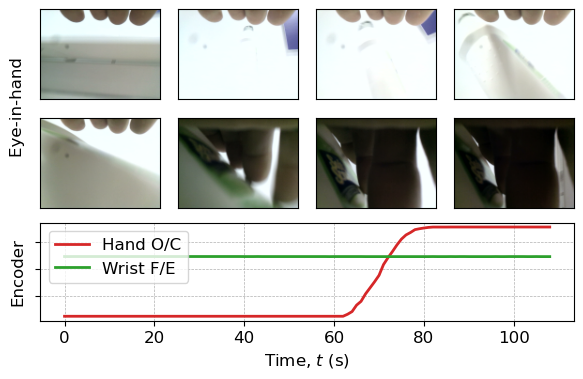

In [45]:
fig = plt.figure(figsize=(6, 4))

rows_grid = 3
cols_grid = 4
gs = gridspec.GridSpec(nrows=rows_grid, ncols=cols_grid, width_ratios=[1, 1, 1, 1], height_ratios=[1, 1, 1])

# eye-in-hand camera
axes_frames = []
for i in range(cols_grid):
    ax = fig.add_subplot(gs[0, i])
    axes_frames.append(ax)
for i in range(cols_grid):
    ax = fig.add_subplot(gs[1, i])
    axes_frames.append(ax)

ax_encoder = fig.add_subplot(gs[-1, :]) # encoder measurements axis

nrows = 2
ncols = 4
pad_frames = 2
start_i = 1
end_i = -1

frame_indeces = np.linspace(start=0, stop=len(frames)-1, num=nrows*ncols + pad_frames, dtype=int)
#frame_indeces = frame_indeces[0:-1] #frame_indeces[1:-1]
frame_indeces = frame_indeces[start_i:end_i]
for ax, index in zip(axes_frames, frame_indeces):
    ax.imshow(frames[index])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

axes_frames[0].set_ylabel('Eye-in-hand' + ' ' * 20) # spaces to center y label between axes

ax_encoder.plot(mes_hand, color='tab:red', linewidth=2, alpha=1, label='Hand O/C')[0]
ax_encoder.plot(mes_wrist_FE, color='tab:green', linewidth=2, alpha=1, label='Wrist F/E')[0]
ax_encoder.set_ylabel('Encoder')
ax_encoder.grid(linewidth=0.5, linestyle='--')
ax_encoder.set_xlabel("Time, $t$ (s)")
ax_encoder.legend(loc='upper left', ncols=1)
ax_encoder.set_yticklabels([])

#plt.savefig(fname='../../figures/test/iros2025/' + name + 'observations.pdf', bbox_inches='tight', dpi=600)
#plt.savefig(fname='../../figures/test/iros2025/' + name + 'observations.png', bbox_inches='tight', dpi=600)
#plt.savefig(fname='../../figures/test/iros2025/' + name + 'observations.svg', bbox_inches='tight', dpi=600)
plt.tight_layout()
plt.show()

#### Episode actions (reference vs predicted)
For simplicity we show only the first action predicted of each action sequence

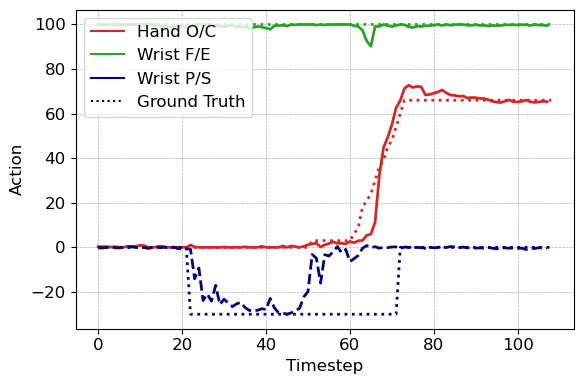

In [71]:
executed_action_sequences = np.array(action_sequences['executed']) # (time, Ta, Da)

fig = plt.figure(figsize=(6, 4))
plt.plot(executed_action_sequences[:, 0, 0], color='tab:red', linewidth=2, alpha=1,)
plt.plot(executed_action_sequences[:, 0, 1], color='tab:green', linewidth=2, alpha=1,)
plt.plot(executed_action_sequences[:, 0, 2], color='navy', linestyle='--', linewidth=2, alpha=1,)

plt.plot(actions_gt[:, 0], color='tab:red', linestyle=':', linewidth=2, alpha=1)
plt.plot(actions_gt[:, 1], color='tab:green', linestyle=':', linewidth=2, alpha=1)
plt.plot(actions_gt[:, 2], color='navy', linestyle=':', linewidth=2, alpha=1)

plt.plot([], color='tab:red', label="Hand O/C")
plt.plot([], color='tab:green', label='Wrist F/E')
plt.plot([], color='navy', linestyle='-', label='Wrist P/S')
plt.plot([], color='black', linestyle=':', label='Ground Truth')

plt.ylabel('Action')
plt.xlabel("Timestep")
plt.grid(linewidth=0.5, linestyle='--')
plt.legend(loc='upper left', ncols=1)

# Adjust layout for clarity
plt.tight_layout()
#plt.savefig(fname='../../figures/test/iros2025/' + name + 'action_predictions.pdf', bbox_inches='tight', dpi=600)
#plt.savefig(fname='../../figures/test/iros2025/' + name + 'action_predictions.png', bbox_inches='tight', dpi=600)
#plt.savefig(fname='../../figures/test/iros2025/' + name + 'action_predictions.svg', bbox_inches='tight', dpi=600)
plt.show()

#### Episode video (frames + predictions)

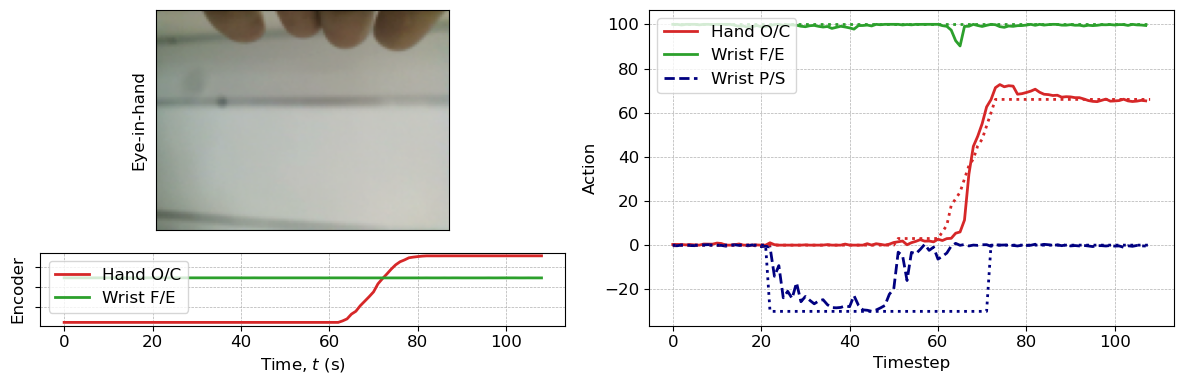

In [89]:
fig = plt.figure(figsize=(12, 4)) # (6,4) for half fig in paper

rows_grid = 3
cols_grid = 5
gs = gridspec.GridSpec(nrows=2, ncols=2, width_ratios=[1, 1], height_ratios=[3, 1])

ax_frames = fig.add_subplot(gs[0, 0])
ax_encoder = fig.add_subplot(gs[1, 0])
ax_action = fig.add_subplot(gs[:, 1])

# eye-in-hand plot
line_img = ax_frames.imshow(frames[0])
ax_frames.set_xticks([])
ax_frames.set_yticks([])
ax_frames.set_ylabel('Eye-in-hand')

# action plot
line_action_pred_1 = ax_action.plot(executed_action_sequences[:, 0, 0], color='tab:red', linewidth=2, alpha=1, label="Hand O/C")[0]
line_action_pred_2 = ax_action.plot(executed_action_sequences[:, 0, 1], color='tab:green', linewidth=2, alpha=1, label='Wrist F/E')[0]
line_action_pred_3 = ax_action.plot(executed_action_sequences[:, 0, 2], color='navy', linestyle='--', linewidth=2, alpha=1, label='Wrist P/S')[0]
ax_action.plot(actions_gt[:, 0], color='tab:red', linestyle=':', linewidth=2, alpha=1)
ax_action.plot(actions_gt[:, 1], color='tab:green', linestyle=':', linewidth=2, alpha=1)
ax_action.plot(actions_gt[:, 2], color='navy', linestyle=':', linewidth=2, alpha=1)
#ax_action.fill_between(x=time_axis_subsample, y1=actions[:, 2], color='navy', linewidth=2, alpha=0.3, label='P/S angular displacement') # NOTE [0] raises plt error (non subscriptable)
ax_action.set_ylabel('Action')
ax_action.grid(linewidth=0.5, linestyle='--')
ax_action.set_xlabel("Timestep")
ax_action.legend(loc='upper left', ncols=1)

# encoder plot
line_mes_1 = ax_encoder.plot(mes_hand, color='tab:red', linewidth=2, alpha=1, label='Hand O/C')[0]
line_mes_2 = ax_encoder.plot(mes_wrist_FE, color='tab:green', linewidth=2, alpha=1, label='Wrist F/E')[0]
ax_encoder.set_ylabel('Encoder')
ax_encoder.grid(linewidth=0.5, linestyle='--')
ax_encoder.set_xlabel("Time, $t$ (s)")
ax_encoder.legend(loc='upper left', ncols=1)
ax_encoder.set_yticklabels([])

# Adjust layout for clarity
plt.tight_layout()

In [ ]:
# Initialize function
def init():
    line_img.set_data([[]])
    line_action_pred_1.set_data([], [])
    line_action_pred_2.set_data([], [])
    line_action_pred_3.set_data([], [])
    line_mes_1.set_data([], [])
    line_mes_2.set_data([], [])

    return line_img, line_action_pred_1, line_action_pred_2, line_action_pred_3, line_mes_1, line_mes_2

# Update function
def update(i):
    line_img.set_data(frames[i])
    line_action_pred_1.set_data(np.arange(0,i), executed_action_sequences[:i, 0, 0])
    line_action_pred_2.set_data(np.arange(0,i), executed_action_sequences[:i, 0, 1])
    line_action_pred_3.set_data(np.arange(0,i), executed_action_sequences[:i, 0, 2])

    line_mes_1.set_data(np.arange(0,i), mes_hand[:i])
    line_mes_2.set_data(np.arange(0,i), mes_wrist_FE[:i])

    return line_img, line_action_pred_1, line_action_pred_2, line_action_pred_3, line_mes_1, line_mes_2

# Create animation
ani = FuncAnimation(fig, update, frames=len(frames), init_func=init, blit=False)
ani.save('./prova.mp4', writer="ffmpeg", fps=20, dpi=600) # TODO: extract time stamps array from demonstrations to build the HannesImitationDataset to get proper fps


#### OLD: Action error over time

```python
action_error_0 = np.mean(np.abs(actions_gt - action_trajectories[:, 0]), axis=1) # no horizon
action_error_1 = np.mean(np.abs(actions_gt[1:] - action_trajectories[:-1, 1]), axis=1) # horizon 1
action_error_2 = np.mean(np.abs(actions_gt[2:] - action_trajectories[:-2, 2]), axis=1) # horizon 2
```

Idea illustrated below (sample time goes right, prediction horizon goes down): [x means that that index is ignored]

for horizon 0 (i.e. 1 step prediction)
- actions_gt      [a0, a1, a2, a3, ..., aN]
- actions_pred_h0 [a00, a10, a20, a30, ... aN0] 

for horizon 1 (i.e., 2 step prediciton)
- actions_gt      [x, a1, a2, a3, ..., a_N]
- actions_pred_h1 [a01, a11, a21, ..., a_(N-1,1), x] 

In [ ]:
action_errors_horizon = {h: None for h in range(action_horizon)}
for h in range(action_horizon):
    a_gt_horizon = actions_gt[h:] # skip the first h actions to get ground truth with horizon h
    if h > 0:
        a_pred_horizon = action_trajectories[:-h, h] # skip last h samples but take the prediction with horizon h starting from the first sample
    else:
        a_pred_horizon = action_trajectories[:, h] # NOTE: this because [:-0] does not work as expected

    # average over action dimension
    action_errors_horizon[h] = np.mean(np.abs(a_gt_horizon - a_pred_horizon), axis=1) # (episode_len, 1)
    #action_errors_horizon[h] = np.abs(a_gt_horizon - a_pred_horizon) # (episode_len, 1)

alphas = np.ones(action_horizon)
alphas[1:] = np.linspace(0.5, 0.1, num=action_horizon-1)

# plot
plt.figure(figsize=(6,3))
plt.plot(action_errors_horizon[h], color='tab:red', linewidth=2, alpha=alphas[0], label='0')

for h in range(1, action_horizon):
    plt.plot(action_errors_horizon[h], color='grey', alpha=alphas[h], label='%d' % h)

plt.xlabel("Control step")
plt.ylabel("Action error")

plt.grid(linewidth=0.5, linestyle='--')
plt.legend(title='Horizon, $T_a$', loc='best', ncols=2)
plt.xlim([50, 100]) # break axis?
plt.show()

for i in range(action_horizon):
    print("horizon %d, MAE: %.2f +- %.2f" % (i, action_errors_horizon[i].mean(), action_errors_horizon[i].std()))

#### Extra: Count parameters

In [99]:
# define function
count_parameters = lambda net: np.sum([np.prod(params.shape) for params in net.parameters()])

unet_count = count_parameters(policy.model)
resnet_count = count_parameters(policy.obs_encoder)

print("UNet parameters:", unet_count)
print("ResNet parameters:", resnet_count)

UNet parameters: 965539
ResNet parameters: 11176512
